### Imports et initialisations

In [2]:
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from clustertools import *

### Récupération des tweets

In [3]:
clean_dataset_file = "datasets/MillionTweetsMinStp_NEFU.txt"

raw_dataset_file = "datasets/MillionTweets_NEFU.txt"

In [4]:
with open(clean_dataset_file, "r") as file:
    lines = file.read().splitlines()
    
# On sépare les messages pour les avoir sous forme de liste de mots.
clean_dataset = [line.split() for line in lines]

with open(raw_dataset_file, "r") as file:
    raw_dataset = file.read().splitlines()

### Création des échantillons

- Le dataset ne tient pas en entier en mémoire, on travaille donc avec un échantillon
- Cet échantillon est sélectionné de manière aléatoire, de façon à avoir des résultats déterministes et donc reproductibles, on utilise une instance de générateur de nombre pseudo aléatoire random.Random avec un seed de 0

In [5]:
sample_size = 5000

idx_list = random.Random(0).sample(range(len(clean_dataset)), sample_size)
clean_dataset = [clean_dataset[i] for i in idx_list]
raw_dataset = [raw_dataset[i] for i in idx_list]

### Récupération des différents mots et de leur nombre d'occurences

Pour l'encodage, nous aurons besoin de connaître la liste des différents mots de notre jeu de données afin d'associer à chacun un nombre.

Pour interpréter les résultats nous aurons besoin de connaître les mots les plus utilisés dans chaque cluster

Pour cela nous utilisons ces fonctions qui permettent d'obtenir une liste des mots du jeu de données (ou d'un sous ensemble comme ce sera le cas avec les clusters) triés par nombre d'occurences décroissant

Ces fonctions sont intégrées au module `clustertools` et ne sont donc recopiées ici que pour illustrer

In [6]:
#Création du dictionnaire de mots avec leur occurence
def create_wdict(lines):
    dico = {}
    for msg in lines:
        for mot in msg:
            if mot in dico: 
                dico[mot] += 1
            else:
                dico[mot] = 1
    return dico

#Création de la liste des mots triée par nombre d'occurences décroissant
def create_sorted_wlist(lines):
    dico = create_wdict(lines)
    wlist = [ (mot, dico[mot]) for mot in dico.keys()]
    return sorted(wlist, key = lambda mot: mot[1], reverse = True)

In [7]:
liste_mots_triee = create_sorted_wlist(clean_dataset)

In [8]:
print("Il y a {} mots différents".format(len(liste_mots_triee)))
print("Les dix mots les plus utilisés sont :")
for mot in liste_mots_triee[:10]:
    print(mot[0], end=' ')

# Comme il y a peu de mots on utilise une taille de dictionnaire égale au nombre de mots différents du jeu de données plus un pour les mots inconnus
dict_len = len(liste_mots_triee) + 1

Il y a 17169 mots différents
Les dix mots les plus utilisés sont :
... ( faire ) bien fait va / être faut 

### Traduction des listes de mots en listes de codes

La première étape de l'encodage est de remplacer les mots par leur code (appelé ici index). 

On crée deux dictionnaires pour l'encodage et le décodage.

Ici nous travaillons avec un échantillon, qui contient 17169 mots différents, on peut donc utiliser un dictionnaire qui contient tous les mots, avec un jeu de données plus grand on limiterait la taille du dictionnaire par exemple à 80 000 mots.

On crée également deux fonctions `encode` et `decode` qui à partir d'une liste de mot renvoient une liste de codes correspondant aux mots ou inversement.

In [9]:
# On réserve le code 0 pour les mots qui ne font pas partie du dictionnaire
word_index_dict = { '<unk>' : 0}
for i, elt in enumerate(liste_mots_triee):
    word_index_dict[elt[0]] = i + 1
    
index_word_dict = { i:word for word,i in word_index_dict.items() }

In [10]:
def encode(msg):
    return [word_index_dict[mot] if mot in word_index_dict else 0 for mot in msg]
        
def decode(msg):
    return ' '.join([index_word_dict[i] for i in msg])

In [11]:
dataset_preencoded = [encode(msg) for msg in clean_dataset]

In [12]:
print(clean_dataset[20])
print(dataset_preencoded[20])
decode(dataset_preencoded[20])

['guéguerre', 'débile']
[4214, 4215]


'guéguerre débile'

### Encodage one-hot proprement dit

Chaque message est transformé en un vecteur de la taille du dictionnaire. Pour chaque mot dans un message, l'indice du vecteur correspondant à ce message est mis à 1, le reste des indices reste à 0.

On commence par créer une matrice ayant un nombre de lignes égal à la taille du jeu de données et un nombre de colonnes égal à la taille du dictionnaire. Chaque ligne de cette matrice représentera un message encodé. Puis on parcourt le jeu de données préencodé où les mots ont été remplacés par leur code et on met à 1 les composantes correspondants aux codes de chaque vecteurs ligne.

In [13]:
def one_hot_encode(dataset, vector_size=dict_len):
    dataset_encoded = np.zeros((len(dataset), vector_size), dtype=np.int)
    for i, msg in enumerate(dataset):
        for code in msg:
            dataset_encoded[i, code] = 1
    return dataset_encoded
    

In [14]:
dataset_encoded = one_hot_encode(dataset_preencoded)

In [15]:
dataset_encoded.shape

(5000, 17170)

### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela la méthode Truncated SVD qui est indiquée dans le cas de données éparses

In [16]:
%%time

#Prend une quarantaine de seconds à exécuter sur ma machine

svd = TruncatedSVD()

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = svd.fit_transform(dataset_encoded)

CPU times: user 20 s, sys: 8.75 s, total: 28.7 s
Wall time: 5.93 s


In [17]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

#Taille des figures
plt.rcParams["figure.figsize"] = (10,10)

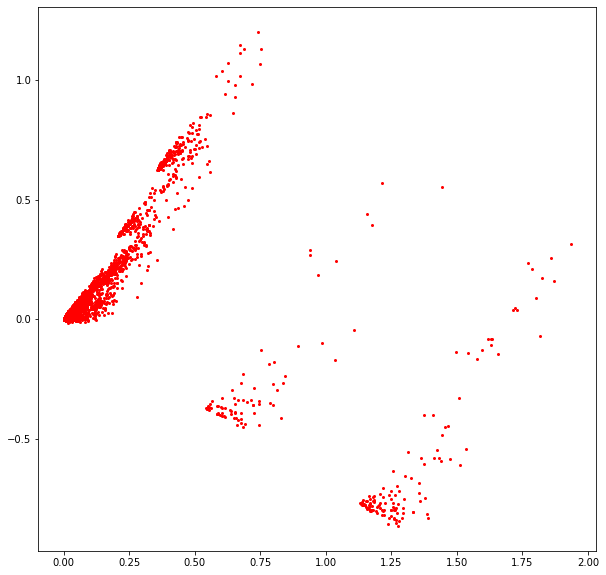

In [18]:
#Affichage des données
plt.plot(b[0], b[1], 'r.')
plt.show()

### Kmeans

In [19]:
n_clust = 8

In [20]:
%%time

kmeans = KMeans(n_clusters=n_clust, random_state=0).fit(dataset_encoded)

CPU times: user 1min 15s, sys: 9.36 s, total: 1min 24s
Wall time: 12 s


In [21]:
km_pred = kmeans.predict(dataset_encoded)

In [22]:
# Initialisation des variables globales pour le module clustertools
init_globals(clean_dataset, raw_dataset, two_dim_dataset, "")

Cluster 0 : 1 messages
0 messages contiennent un mot-clé haineux (soit 0.00%)
Les 15 mots les plus fréquents : photos demande prouver ticket caisse, publiées. pop petite procéder vérification. contact acheteuse. explique comprends etc. 


Cluster 1 : 4540 messages
33 messages contiennent un mot-clé haineux (soit 0.73%)
Les 20 mots les plus fréquents : jour sais dm genre moment tweet soir envie bonjour + veut vidéo parler novembre * mds allez mdrr gros vont 


Cluster 2 : 163 messages
4 messages contiennent un mot-clé haineux (soit 2.45%)
Les 20 mots les plus fréquents : mdrr froid font parler penser gagner compte bcp soir 10 vite aucune 4 jeu m. vont choses argent bref gars 


Cluster 3 : 16 messages
0 messages contiennent un mot-clé haineux (soit 0.00%)
Les 20 mots les plus fréquents : vas -ce autoriser répond armes jure #hellbound tuerie m'étonne amie persistent, qu'voulait plaindre sûrement châtiment abattre membre fn rn défiler 


Cluster 4 : 1 messages
0 messages contiennent un mo

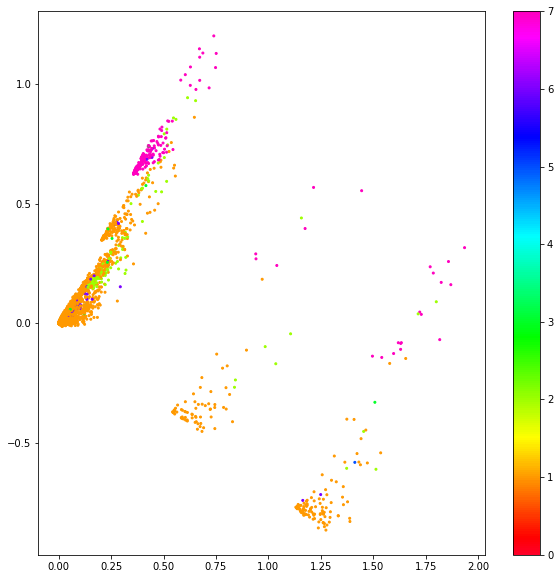

In [23]:
parse_no_save(km_pred)

### SOM

In [24]:
from minisom import MiniSom

In [25]:
m = 3
n = 3
som = MiniSom(m, n, dict_len, neighborhood_function='gaussian', random_seed=0)

In [27]:
som.random_weights_init(dataset_encoded)

In [28]:
%%time

n_epoch = 100000

som.train(dataset_encoded, n_epoch, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 2.4349588583813353
CPU times: user 2min 2s, sys: 3.23 s, total: 2min 5s
Wall time: 1min 50s


In [31]:
%%time
som_pred = []
for msg in dataset_encoded:
    winner = som.winner(msg)
    som_pred.append(winner[0]*n+winner[1])

CPU times: user 1.7 s, sys: 0 ns, total: 1.7 s
Wall time: 1.7 s


Cluster 0 : 153 messages
3 messages contiennent un mot-clé haineux (soit 1.96%)
Les 20 mots les plus fréquents : parler sais veut passe coup vont tantouze vas genre jsp soir .... prendre vacciner envie sait ouin test lieu dois 


Cluster 1 : 101 messages
2 messages contiennent un mot-clé haineux (soit 1.98%)
Les 20 mots les plus fréquents : peuvent vivre grave nuit jeunes réalité pourrait politique partir liberté peur amp; devrait compte police terrible niveau disant élevé foot 


Cluster 2 : 132 messages
1 messages contiennent un mot-clé haineux (soit 0.76%)
Les 20 mots les plus fréquents : usdt vol cas saison ), demande 24h points ). radio nan coup novembre soir 2021 price jours afrique milieu mdrr 


Cluster 3 : 202 messages
5 messages contiennent un mot-clé haineux (soit 2.48%)
Les 20 mots les plus fréquents : .... rapport novembre question vaccin milliards ensemble https//t.co pouvoir vois argent article belle air amp; niveau peur chance député part 


Cluster 4 : 8 messages
0 mes

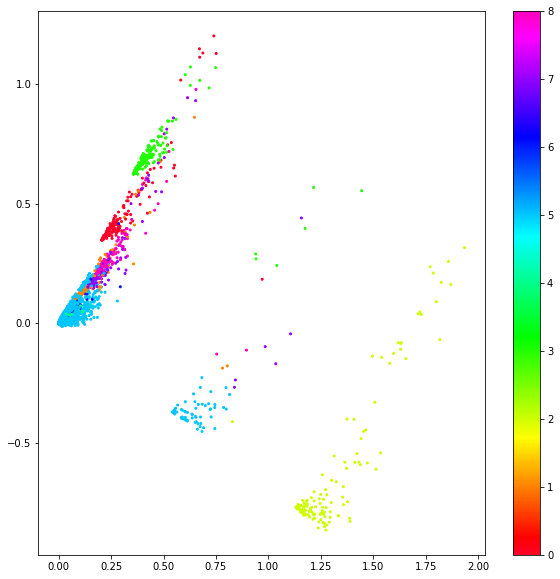

In [32]:
parse_no_save(som_pred)